# Titanic Survival Classification
An application of Titanic dataset to classification of survivals

## Libraries

In [72]:
import os
import warnings

import numpy as np 
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import RandomizedSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

## Data

In [18]:
data_dir = '../data/titanic/'

train_file = 'train.csv'
test_file = 'test.csv'

train_path = os.path.join(data_dir, train_file)
test_path = os.path.join(data_dir, test_file)

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## EDA

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [20]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [21]:
df_train.describe(include = 'O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [22]:
df_train.groupby('Survived').agg({'PassengerId': 'count'})

,PassengerId
Survived,
0,549
1,342


In [23]:
# 1st class survivors are at the highest rate whereas 3rd class survivors are at the lowest. So important feature. Keep it!
df_train.groupby('Pclass').agg({'Survived': 'sum', 'PassengerId': 'count'}).eval("Survived / PassengerId * 100")

Pclass
1    62.962963
2    47.282609
3    24.236253
dtype: float64

In [24]:
df_train["Title"] = df_train["Name"].str.extract('([A-Za-z]+)\.')
df_test["Title"] = df_test["Name"].str.extract('([A-Za-z]+)\.')

def convert_title(title):
    if title in ["Ms", "Mile", "Miss"]:
        return "Miss"
    elif title in ["Mme", "Mrs"]:
        return "Mrs"
    elif title == "Mr":
        return "Mr"
    elif title == "Master":
        return "Master"
    else:
        return "Other"
        
df_train["Title"] = df_train["Title"].map(convert_title)
df_test["Title"] = df_test["Title"].map(convert_title)

df_train.drop("Name", axis=1, inplace=True)
df_test.drop("Name", axis=1, inplace=True)

df_train.groupby('Title').agg({'PassengerId': 'count'})

,PassengerId
Title,
Master,40
Miss,183
Mr,517
Mrs,126
Other,25


In [25]:
# The gender matters to survive according to the data. Keep it!
df_train.groupby('Sex').agg({'Survived': 'sum', 'PassengerId': 'count'}).eval("Survived / PassengerId")

Sex
female    0.742038
male      0.188908
dtype: float64

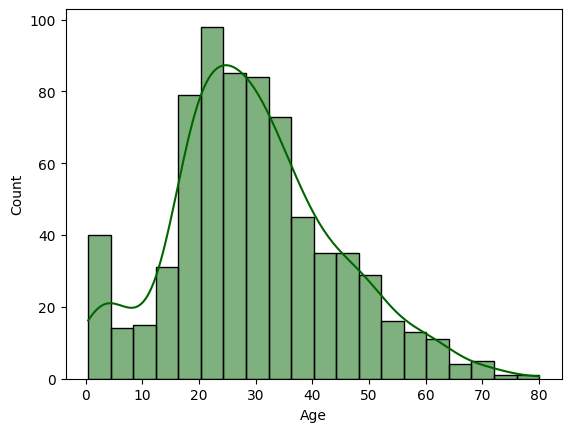

In [27]:
sns.histplot(data=df_train, x='Age', color='darkgreen', kde=True)
plt.show()

In [28]:
df_train.groupby('SibSp').agg({'Survived': 'sum', 'PassengerId': 'count'}).eval("Survived / PassengerId")

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
dtype: float64

In [29]:
df_train.groupby('Parch').agg({'Survived': 'sum', 'PassengerId': 'count'}).eval("Survived / PassengerId")

Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
dtype: float64

In [30]:
df_train.drop("Ticket", axis=1, inplace=True)
df_test.drop("Ticket", axis=1, inplace=True)

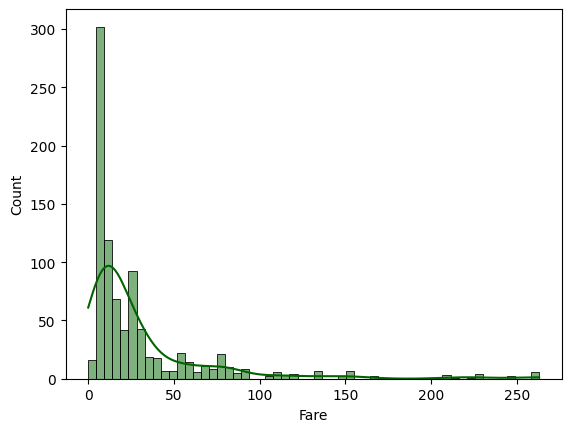

In [31]:
sns.histplot(data=df_train[df_train['Fare']<500], x='Fare', kde=True, color='darkgreen')
plt.show()

In [32]:
df_train.drop("Cabin", axis=1, inplace=True)
df_test.drop("Cabin", axis=1, inplace=True)

In [33]:
df_train.groupby('Embarked').agg({'Survived': 'sum', 'PassengerId': 'count'}).eval("Survived / PassengerId")

Embarked
C    0.553571
Q    0.389610
S    0.336957
dtype: float64

## Missing Data

In [34]:
df_train.isna().sum()[df_train.isna().sum() > 0]

Age         177
Embarked      2
dtype: int64

In [35]:
df_test.isna().sum()[df_test.isna().sum() > 0]

Age     86
Fare     1
dtype: int64

In [36]:
df_train['Embarked'].fillna('S', inplace=True)

Could be done better below.

In [51]:
df_train['Age'] = df_train['Age'].fillna(df_train.groupby(['Pclass', 'Sex']).Age.transform('median'))
df_test['Age'] = df_test['Age'].fillna(df_test.groupby(['Pclass', 'Sex']).Age.transform('median'))

In [60]:
df_test.Fare.fillna(df_test.groupby("Pclass").Fare.mean()[3], inplace=True)

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
 9   Title        891 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 69.7+ KB


In [62]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
 8   Title        418 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.5+ KB


## Feature Engineering

In [63]:
df_train['SP'] = df_train["SibSp"] + df_train["Parch"]
df_train['isAlone'] = np.where(df_train['SP'] > 0, 0, 1)

df_test['SP'] = df_test["SibSp"] + df_test["Parch"]
df_test['isAlone'] = np.where(df_test['SP'] > 0, 0, 1)

In [64]:
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

In [65]:
df_train.drop(columns=['SibSp', 'Parch', 'SP', 'PassengerId'], inplace=True)
df_test.drop(columns=['SibSp', 'Parch', 'SP', 'PassengerId'], inplace=True)

In [66]:
df_train = pd.get_dummies(df_train, prefix=["Embarked", "Title"])
df_test = pd.get_dummies(df_test, prefix=["Embarked", "Title"])

In [67]:
df_train.drop(columns=['Embarked_S', 'Title_Other'], inplace=True)
df_test.drop(columns=['Embarked_S', 'Title_Other'], inplace=True)

## Model

### Dataset
Split X and y

In [86]:
X_train = df_train.drop("Survived", axis=1)
y_train = df_train.Survived

X_test = df_test.copy()

### Feature Scaling

In [87]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Model Selection

In [88]:
classifiers = {
    "KNN": KNeighborsClassifier(), 
    "LR": LogisticRegression(max_iter=1000), 
    "DT": DecisionTreeClassifier(),
    "RF": RandomForestClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier(max_iter=1000),
    "XGB": XGBClassifier()
}

results = pd.DataFrame(columns=["Classifier", "Avg_Accuracy", "Avg_F1_Score"])
for name, clf in classifiers.items():
    model = clf
    cv_results = cross_validate(
        model, X_train_scaled, y_train, cv=10,
        scoring=(['accuracy', 'f1'])
    )

    results = pd.concat([results, pd.DataFrame({
        "Classifier": name,
        "Avg_Accuracy": cv_results['test_accuracy'].mean(),
        "Avg_F1_Score": cv_results['test_f1'].mean()
    }, index=[0])], ignore_index=True)
    
results = results.sort_values(by='Avg_Accuracy', ascending=False)
results

,Classifier,Avg_Accuracy,Avg_F1_Score
4,SVM,0.822709,0.738318
5,MLP,0.819351,0.747433
6,XGB,0.819351,0.758250
0,KNN,0.812659,0.742503
1,LR,0.808152,0.742333
3,RF,0.801423,0.735616
2,DT,0.785693,0.718597


In [94]:
cv_results

{'fit_time': array([0.27599406, 0.04366612, 0.04589105, 0.076792  , 0.04148197,
        0.04206681, 0.0401001 , 0.04115033, 0.04545522, 0.03853393]),
 'score_time': array([0.00129986, 0.00121403, 0.00125909, 0.00234294, 0.0012579 ,
        0.00117803, 0.00122809, 0.00120568, 0.00137877, 0.00126696]),
 'test_accuracy': array([0.77777778, 0.84269663, 0.74157303, 0.84269663, 0.87640449,
        0.83146067, 0.87640449, 0.75280899, 0.83146067, 0.82022472]),
 'test_f1': array([0.71428571, 0.78125   , 0.62295082, 0.81081081, 0.84057971,
        0.7761194 , 0.82539683, 0.64516129, 0.79452055, 0.77142857])}

### Hyperparameter Tuning for XGB

In [89]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_train_scaled)

    # Evaluate predictions
    accuracy = accuracy_score(y_train, y_pred)
    return accuracy

In [90]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-09-07 22:59:18,330] A new study created in memory with name: no-name-eb9fc4cd-0374-48af-9626-cf71e1b9e24d
[I 2023-09-07 22:59:18,379] Trial 0 finished with value: 0.819304152637486 and parameters: {'max_depth': 9, 'learning_rate': 0.6096580287713476, 'n_estimators': 234, 'min_child_weight': 9, 'gamma': 3.395397836653097e-05, 'subsample': 0.1046266727606093, 'colsample_bytree': 0.29609548035284294, 'reg_alpha': 0.00019910160208878272, 'reg_lambda': 1.0563768313877005e-08}. Best is trial 0 with value: 0.819304152637486.
[I 2023-09-07 22:59:18,414] Trial 1 finished with value: 0.6161616161616161 and parameters: {'max_depth': 6, 'learning_rate': 0.025295909648708804, 'n_estimators': 260, 'min_child_weight': 6, 'gamma': 0.003800648160410852, 'subsample': 0.03233636460221781, 'colsample_bytree': 0.40989324437320857, 'reg_alpha': 2.2390627169935163e-08, 'reg_lambda': 0.6459969750520306}. Best is trial 0 with value: 0.819304152637486.
[I 2023-09-07 22:59:18,446] Trial 2 finished with v

In [91]:
trial = study.best_trial
params = trial.params
model = XGBClassifier(**params)
model.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8879340573376019, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.06278266105822616, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.7912305149010421, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Train Accuracy: 0.9820426487093153
Train F1-Score: 0.976401179941003


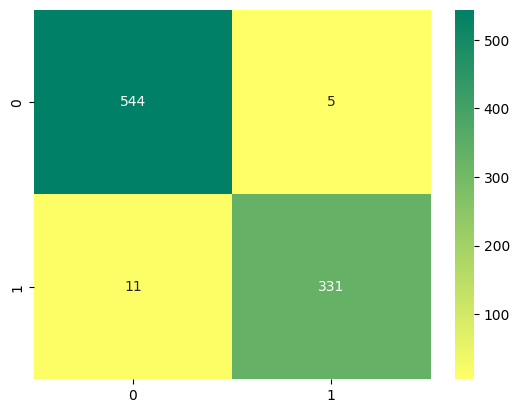

In [92]:
y_pred = model.predict(X_train_scaled)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Train F1-Score: {f1_score(y_train, y_pred)}")
sns.heatmap(confusion_matrix(y_train, y_pred), fmt='.3g', annot=True, cmap='summer_r')
plt.show()

In [93]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       549
           1       0.99      0.97      0.98       342

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



### Hyperparameter Tuning for SVC

In [96]:
def objective(trial):
    """Define the objective function"""

    params = {
        'C': trial.suggest_int('C', 1, 100),
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
    }
    
    if params['kernel'] == 'poly':
            params['degree'] = trial.suggest_int('degree', 1, 5)

    # Fit the model
    optuna_model = SVC(**params)
    optuna_model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = optuna_model.predict(X_train_scaled)

    # Evaluate predictions
    accuracy = accuracy_score(y_train, y_pred)
    return accuracy

In [100]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-09-07 23:14:13,706] A new study created in memory with name: no-name-55fa5767-b21d-4121-a153-0c6c8069cb36
[I 2023-09-07 23:14:13,739] Trial 0 finished with value: 0.8619528619528619 and parameters: {'C': 75, 'kernel': 'poly', 'gamma': 'scale', 'degree': 4}. Best is trial 0 with value: 0.8619528619528619.
[I 2023-09-07 23:14:13,774] Trial 1 finished with value: 0.8686868686868687 and parameters: {'C': 89, 'kernel': 'poly', 'gamma': 'scale', 'degree': 5}. Best is trial 1 with value: 0.8686868686868687.
[I 2023-09-07 23:14:13,793] Trial 2 finished with value: 0.8574635241301908 and parameters: {'C': 13, 'kernel': 'poly', 'gamma': 'scale', 'degree': 3}. Best is trial 1 with value: 0.8686868686868687.
[I 2023-09-07 23:14:13,818] Trial 3 finished with value: 0.8597081930415263 and parameters: {'C': 34, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 1 with value: 0.8686868686868687.
[I 2023-09-07 23:14:13,830] Trial 4 finished with value: 0.8552188552188552 and parameters: {'C': 6, 

In [101]:
trial = study.best_trial
params = trial.params
model = SVC(**params)
model.fit(X_train_scaled, y_train)

SVC(C=46, degree=5, gamma='auto', kernel='poly')

Train Accuracy: 0.8698092031425365
Train F1-Score: 0.8116883116883117


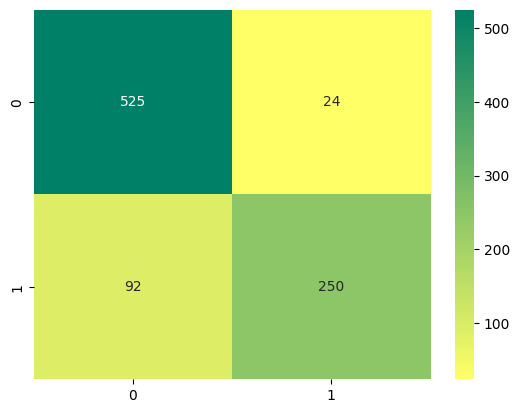

In [102]:
y_pred = model.predict(X_train_scaled)
print(f"Train Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"Train F1-Score: {f1_score(y_train, y_pred)}")
sns.heatmap(confusion_matrix(y_train, y_pred), fmt='.3g', annot=True, cmap='summer_r')
plt.show()

In [ ]:
# y_pred = clf.predict(X_test_scaled)
y_pred = model.predict(X_test_scaled)

submission_pre_path = os.path.join(data_dir, 'gender_submission.csv')
submission_path = os.path.join(data_dir, 'submission.csv')

submission = pd.read_csv(submission_pre_path)
submission["Survived"] = y_pred
submission.to_csv(submission_path, index=False)